# Project5 : vehicle detection

### I'm going to build a model that can detect vehicles. That being said, given an image input, the model must identify if the input contains a car or not. This predictions of the model would be a value of number between 0 and 1. The more the value is close to 1, the bigger chance the input contains a car. On the other hand, the more the value is close to 0, the smaller chance the input contains a car. To implement this, i'm not using SVM but a CNN net in Keras instead.

<br/>
<br/>
The reasons are:
<li>CNN is good at image classifiication.</li>
<li>Due to the simplicity of Keras's API, a complex model can be built in just few minutes.</li>
<li>Using TensorFlow backend, the GPU based training makes the process super fast. </li>

### Dependencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
import glob
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

### Load datasets
The dataset is from GTI and Kitti. With around 10,238 non-images and 8,792 car images.

In [2]:
datasets = {
            'car_dataset':{
                'GTI_far' : r'dataset\vehicles\GTI_Far',
                'GTI_left' : r'dataset\vehicles\GTI_Left',
                'GTI_mid' : r'dataset\vehicles\GTI_MiddleClose',
                'GTI_right' : r'dataset\vehicles\GTI_Right',
                'kitti' : r'dataset\vehicles\KITTI_extracted'
                },
            'non_car_dataset':{
                'Extras' : r'dataset\non-vehicles\Extras',
                'GTI' : r'dataset\non-vehicles\GTI'
                }
            }

In [3]:
car_imgs, non_car_imgs = [], []

for cate in datasets:
    if cate == 'car_dataset':
        for folder in datasets[cate]:
            car_imgs += glob.glob('{}/*'.format(datasets[cate][folder]))
    else:
        for folder in datasets[cate]:
            non_car_imgs += glob.glob('{}/*'.format(datasets[cate][folder]))
print('Data loading done ! There are {} car images, and {} non car images.'.format(len(car_imgs), len(non_car_imgs)))

Data loading done ! There are 8792 car images, and 10238 non car images.


## Features extraction
### Extraction of HOG, color and spatial features
I tried with various ways of different combinations of color spaces and HOG parameters and trained a Neuron Network using different combinations of HOG features extracted from the color channels. I was using HLS color space for Hog extraction, because it has the most stable features. Some other important features such like binned color features and color histogram are also used. Color spaces like YUV and YCrCb also provided good results, but are relatively unstable compared to HLS. I finally settled with HLS space and a value of pixels_per_cell=(16,16), orient=9, cells_per_block=(2,2), spatial_size = (16, 16), hist_bins = 16. A feature vector has 1,788 parameters.

In [5]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

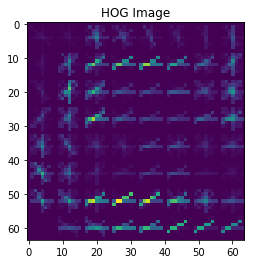

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block), 
        transform_sqrt=True, 
        visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else: 
        features = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block), 
        transform_sqrt=True, 
        visualise=vis, feature_vector=feature_vec)
        return features

feature_image = cv2.imread(car_imgs[0])
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog_image)
plt.title('HOG Image')
plt.show()

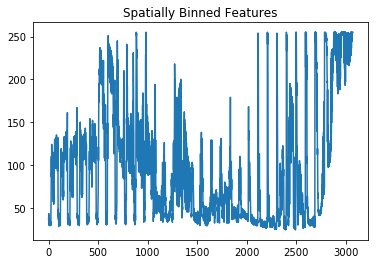

In [8]:
# Define a function to compute binned color features 
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Plot features
feature_image = cv2.imread(car_imgs[0])
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(feature_image, size=spatial_size)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

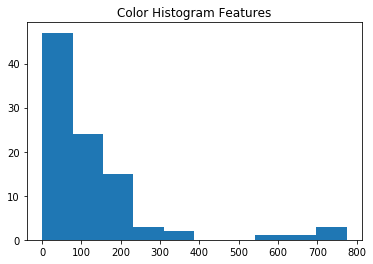

In [9]:
 # Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

feature_image = cv2.imread(car_imgs[0])
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hist_features = color_hist(feature_image, nbins=hist_bins)
plt.hist(hist_features)
plt.title('Color Histogram Features')
plt.show()

In [10]:
 # Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
    hist_bins=32, orient=9, 
    pix_per_cell=8, cell_per_block=2, hog_channel=0,
    spatial_feat=True, hist_feat=True, hog_feat=True, hog_features=None): 
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img) 
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if True: #hog_features is None:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)) 
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)

    #8) Append features to list
#     spatial_scaler = StandardScaler().fit(img_features[0])
#     scaled_spatial = spatial_scaler.transform(img_features[0])

#     hist_scaler = StandardScaler().fit(img_features[0])
#     scaled_hist = hist_scaler.transform(img_features[0])

#     hog_scaler = StandardScaler().fit(img_features[1])
#     scaled_hog = hog_scaler.transform(img_features[1])

    output = np.concatenate(img_features)

    #9) Return concatenated array of features
    return output

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
    hist_bins=32, orient=9, 
    pix_per_cell=8, cell_per_block=2, hog_channel=0,
    spatial_feat=True, hist_feat=True, hog_feat=True, input_type = 'fileName'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img = cv2.imread(file) if input_type == 'fileName' else file
        file_features = single_img_features(img, color_space, spatial_size,
        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
        spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

In [13]:
def preprocessed_images():
    car_features = extract_features(car_imgs, color_space=color_space, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    spatial_size = spatial_size, hist_bins = hist_bins,
                                    hog_channel=hog_channel, spatial_feat = False, 
                                    hist_feat = True)

    noncar_features = extract_features(non_car_imgs, color_space=color_space, orient=orient, 
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                       spatial_size = spatial_size, hist_bins = hist_bins,
                                       hog_channel=hog_channel, spatial_feat = False, 
                                       hist_feat = True)

    car_features = np.array(car_features)
    noncar_features = np.array(noncar_features)
#     print(car_features.shape, noncar_features.shape)
    
    # # Define the Features vector
    X = np.vstack((car_features, noncar_features)).astype(np.float64) 
    
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

    # # Split up data into randomized training and test sets
    # rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)
    
    return X_train, X_test, y_train, y_test, X_scaler

## Training Data

In [73]:
X_train, X_test, y_train, y_test, X_scaler = preprocessed_images()

## Model
I used a SVM model at the first place with grid searching method for parameter optimization. However, using grid searching makes the training process way too long, it's up to 20 minutes to be done with all 18,000 non-veicle and vehicle samples. The SVM model showed a 98% accuracy on test set, but it's not as good as it seemed like, since it occured a great amount of false Positives when working on the video data in this project. Due to those reasons, a Neuron Network based model was finally used  because it performed a better accuracy of 99.5%, fewer false Positives  and much less training time using GPU.

In [75]:
from keras.layers import Dense
from keras.models import Sequential

In [77]:
model = Sequential()
model.add(Dense(1024, input_shape = (4800, ), activation='relu'))
model.add(Dense(512, input_shape = (1664, ), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 10, batch_size = 1024, validation_data=(X_test, y_test))

keras.models.save_model(model, 'model.h5')

Train on 15224 samples, validate on 3806 samples
Epoch 1/10
15224/15224 [==============================] - ETA: 7s - loss: 0.7392 - acc: 0.532 - ETA: 4s - loss: 0.4811 - acc: 0.713 - ETA: 2s - loss: 0.3491 - acc: 0.800 - ETA: 2s - loss: 0.2845 - acc: 0.843 - ETA: 1s - loss: 0.2360 - acc: 0.871 - ETA: 1s - loss: 0.2095 - acc: 0.889 - ETA: 1s - loss: 0.1855 - acc: 0.903 - ETA: 0s - loss: 0.1707 - acc: 0.912 - ETA: 0s - loss: 0.1590 - acc: 0.919 - ETA: 0s - loss: 0.1500 - acc: 0.925 - ETA: 0s - loss: 0.1396 - acc: 0.931 - ETA: 0s - loss: 0.1308 - acc: 0.936 - ETA: 0s - loss: 0.1230 - acc: 0.940 - ETA: 0s - loss: 0.1163 - acc: 0.943 - 1s - loss: 0.1110 - acc: 0.9467 - val_loss: 0.0265 - val_acc: 0.9916
Epoch 2/10
15224/15224 [==============================] - ETA: 0s - loss: 0.0123 - acc: 0.996 - ETA: 0s - loss: 0.0103 - acc: 0.997 - ETA: 0s - loss: 0.0096 - acc: 0.998 - ETA: 0s - loss: 0.0087 - acc: 0.998 - ETA: 0s - loss: 0.0080 - acc: 0.998 - ETA: 0s - loss: 0.0078 - acc: 0.998 - ETA: 0

In [11]:
model = keras.models.load_model('model.h5')

Using TensorFlow backend.


### Sliding window
A sliding window slides over a given image, goes top to bottom and left to right then return the contents at the current position. The classifier we trained will tell us if a car is in the current position.

In [ ]:
def sliding_window(image, startPoint_x = 0, endPoint_x = 0, startPoint_y = 0, endPoint_y = 0, stepSize = 50, windowSize = 100):
    startPoint_x = 0 if startPoint_x == None else startPoint_x
    startPoint_y = 0 if startPoint_y == None else startPoint_y
    
    
    endPoint_x = image.shape[1] if endPoint_x == None else endPoint_x
    endPoint_y = image.shape[0] if endPoint_y == None else endPoint_y
#  print(startPoint_x, endPoint_x, stepSize)
    # slide a window across the image
    for y in range(startPoint_y, endPoint_y, stepSize):
        for x in range(startPoint_x, endPoint_x, stepSize):
            current_area = image[y:y + windowSize,x:x + windowSize,:]
            yield x, y, x + windowSize, y + windowSize, current_area

In [30]:
def detection(image):
    
    sw_x_limits = [ [640, 1000],
                    [900, None],
                    [640, None]]

    sw_y_limits = [[390, 470],
                   [390, 500],
                   [390, 720]]

    sw_window_size = [80, 96, 180]
    
    overlap = [ 0.1, 0.2, 0.2]
    
    output = image.copy()
    heatmaps = []
    
    # Loop through all windows that have different sizes
    for i in range(len(sw_x_limits)):
        # An image thats highlights the detected cars
        canvas = image.copy()
        # Define a list to store all contents captured by the sliding wondow
        # Will be sent to the classifier and See if a car is in each of the images
        slidingWindow_extractions= []
        # Define a list to store the possible areas that contain cars
        contours = []
        for x, y, x2, y2, block_pixels in sliding_window(image, 
                                                         sw_x_limits[i][0], 
                                                         sw_x_limits[i][1], 
                                                         sw_y_limits[i][0], 
                                                         sw_y_limits[i][1],
                                                         stepSize = int(sw_window_size[i] * overlap[i]), 
                                                         windowSize = sw_window_size[i]):
            
            if block_pixels.shape[0] == block_pixels.shape[1] and block_pixels.shape[2] == 3:
                block_pixels = cv2.resize(block_pixels, (64, 64))
                slidingWindow_extractions.append(block_pixels)
                contours.append([x, y, x2, y2])
                
#                 if i == 0:
#                     cv2.rectangle(output, (x, y), (x2, y2), (0, 255, 0), 3)                
#                 if i == 1:
#                     cv2.rectangle(output, (x, y), (x2, y2), (0, 0, 255), 3)
#                 elif i == 2:
#                     cv2.rectangle(output, (x, y), (x2, y2), (255, 0, 0), 3)

        car_features = extract_features(slidingWindow_extractions, color_space=color_space, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    spatial_size = spatial_size, hist_bins = hist_bins,
                                    hog_channel=hog_channel, spatial_feat = False, 
                                    hist_feat = True, input_type = 'a')
    
        # Create a heat map for car detection
        heat_map = np.zeros(canvas.shape[:2]).astype(np.uint8)
        
        # Loop through every single image h=that captured by the sliding window
        # If it is possibly a car, draw it on the heatmap
        for i, feature in enumerate(car_features):
            feature = X_scaler.transform(feature)
#             feature = rescaled_data(feature)
#             pred = clf.predict(feature)
            feature = np.array([feature])
            pred = model.predict(feature)
            if pred > 0.5:
                point1_x = contours[i][0]
                point1_y = contours[i][1]
                point2_x = contours[i][2]
                point2_y = contours[i][3]
                heat_map[point1_y:point2_y,point1_x:point2_x] += 1
        heatmaps.append(heat_map)
        
    far = heatmaps[0]
    far_threshold = np.zeros_like(far)
    far_threshold[far > 4] = 255
    
    far2 = heatmaps[1]
    far2_threshold = np.zeros_like(far2)
    far2_threshold[far2 > 4] = 255
    
    far3 = heatmaps[1]
    far3_threshold = np.zeros_like(far3)
    far3_threshold[far3 > 2] = 255
    
#    
    combined = far_threshold + far2_threshold + far3_threshold
    
    _, cnts, _ = cv2.findContours(combined.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        if not h*w < 200: 
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
#             cv2.addWeighted(output, 1, draw, 0.3, 0)

#     return far, far2, far3, output
#     return far, far2, far3, output
#     return canvas, output
    return output

In [25]:
def preprocessedFrame(image):
    far, far2, output = detection(image)
    newSize = 1 / 5
    span = 20
    window_width = int(image.shape[1] * newSize)
    window_height = int(image.shape[0] * newSize)
    resized_far = cv2.resize(far, (window_width, window_height))
    resized_far = np.dstack((resized_far, resized_far, resized_far))*10
    resized_far2 = cv2.resize(far2, (window_width, window_height))
    resized_far2 = np.dstack((resized_far2, resized_far2, resized_far2))*10
    window1_startPoint_x = span
    window1_startPoint_y = image.shape[0] // 2
    window1_endPoint_x = window1_startPoint_x + window_width
    window1_endPoint_y = window1_startPoint_y + window_height
    
    window2_startPoint_x = span
    window2_startPoint_y = window1_startPoint_y + window_height + span
    window2_endPoint_x = window2_startPoint_x + window_width
    window2_endPoint_y = window2_startPoint_y +  window_height
    
    output[window1_startPoint_y:window1_endPoint_y,window1_startPoint_x:window1_endPoint_x,:] = resized_far
    output[window2_startPoint_y:window2_endPoint_y,window2_startPoint_x:window2_endPoint_x,:] = resized_far2
    
    return output
    

In [21]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(X_scaler, open(scalerfile, 'wb'))

In [22]:
import pickle
scalerfile = 'scaler.sav'
X_scaler = pickle.load(open(scalerfile, 'rb'))

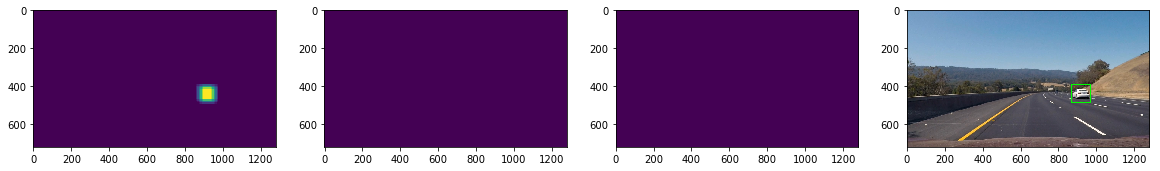

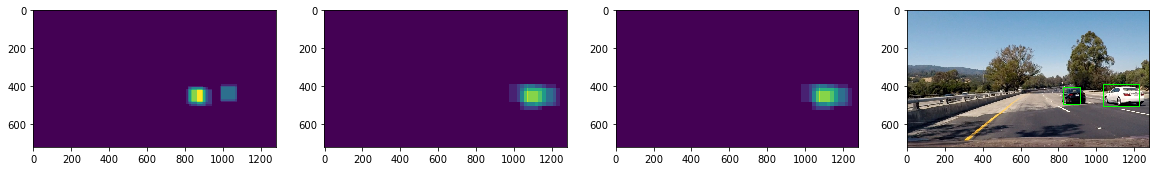

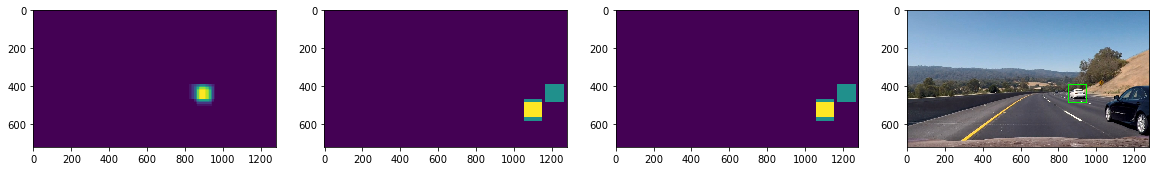

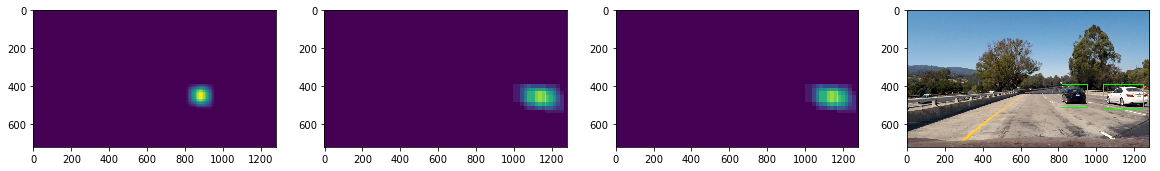

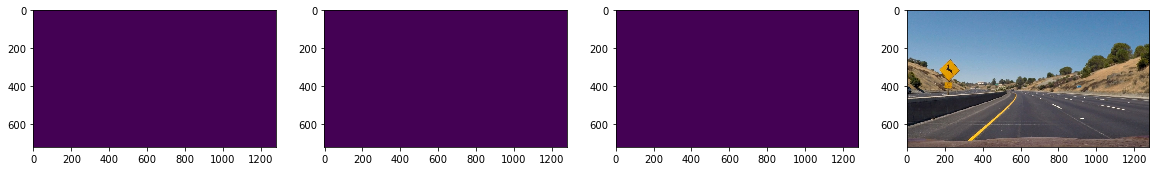

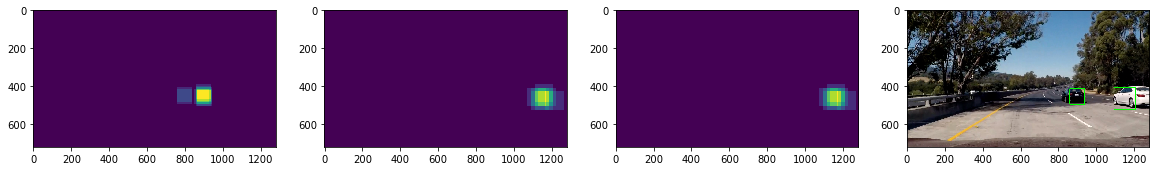

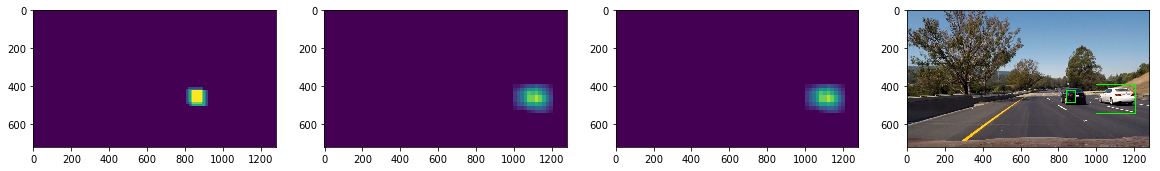

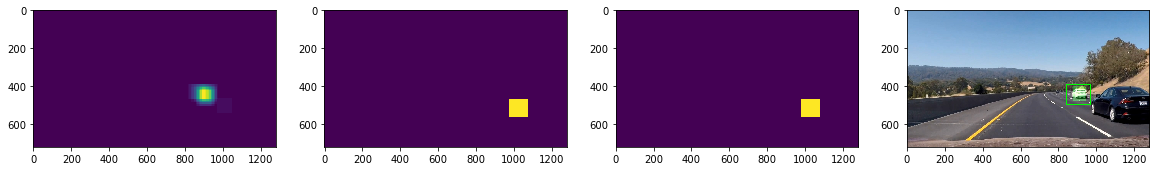

In [29]:
# path = r'test_imgs\test9.jpg'
paths = glob.glob('test_imgs\*')

for path in paths:
    img = mpimg.imread(path)
#     features = single_img_features(img, color_space=color_space, orient=orient, 
#                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
#                                     spatial_size = spatial_size, hist_bins = hist_bins,
#                                     hog_channel=hog_channel, spatial_feat = True, 
#                                     hist_feat = True)
    far, far2, far3, output = detection(img)
    _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
    ax1.imshow(far)
    ax2.imshow(far2)
    ax3.imshow(far3)
    ax4.imshow(output)
    plt.show()
    
#     output = detection(img)
#     plt.imshow(output)
#     plt.show()

In [20]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Set up lines for left and right
white_output = 'far_heatmap_v2.mp4'
clip1 = VideoFileClip("project_video_short.mp4")
white_clip = clip1.fl_image(detection) #NOTE: this function expects color images!!?
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video far_heatmap_v2.mp4
[MoviePy] Writing video far_heatmap_v2.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [10:01<00:00,  1.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: far_heatmap_v2.mp4 

Wall time: 10min 1s


In [32]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Set up lines for left and right
white_output = 'final02.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detection) #NOTE: this function expects color images!!?
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video final02.mp4
[MoviePy] Writing video final02.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:12:09<00:03,  3.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final02.mp4 

Wall time: 1h 12min 10s
